In [2]:
# Fruit Classification using Custom CNN (Apple, Banana, Orange)

import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Image settings
img_size = (100, 100)
batch_size = 32
epochs = 10

# Paths to dataset
train_dir = "C:/Users/LENOVO/Desktop/subjects/computer vision/project/Fruit-Images-Dataset/Train"
test_dir = "C:/Users/LENOVO/Desktop/subjects/computer vision/project/Fruit-Images-Dataset/Test"

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'  # One-hot encode the class labels
)

# Load test data
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'  # One-hot encode the class labels
)

# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),  #Learns 32 filters of size 3x3
    MaxPooling2D(2, 2), # 2x2 blocks from the input and return only the maximum value from each block.

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(), # 2D feature to 1D 
    Dense(128, activation='relu'), # Fully connected layer with 128 neurons each with relu activation function 
    Dropout(0.5),  #Randomly turns off 50% of neurons to prevent overfitting
    Dense(train_data.num_classes, activation='softmax') 
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',          # validation loss
    patience=3,                  # 3 epochs of no improvement
    restore_best_weights=True    # Restore the best weights seen during training
)
# Train the model
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=test_data,
    callbacks=[early_stop]
)

# Evaluate the model
loss, acc = model.evaluate(test_data)
print("\n Final Test Accuracy: {:.2f}%".format(acc * 100))

# Save the model (optional)
model.save("fruit_classifier_cnn.h5")


Found 359 images belonging to 9 classes.
Found 130 images belonging to 9 classes.


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

In [3]:
import cv2
import numpy as np
import os
from random import choice
import matplotlib.pyplot as plt

IMG_SIZE = (128, 128)

# ------------------- Preprocessing Functions -------------------

def load_image(path):
    return cv2.imread(path)

def resize(img, size=IMG_SIZE):
    return cv2.resize(img, size)

def apply_gaussian_blur(img, ksize=(5, 5), sigma=1.0):
    return cv2.GaussianBlur(img, ksize, sigma)

def convert_to_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

def apply_histogram_equalization(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)  #(Hue, Saturation, Value)
    v_eq = cv2.equalizeHist(v)
    hsv_eq = cv2.merge([h, s, v_eq])
    return cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2BGR)

def augment_image(img):
    if choice([True, False]):
        img = cv2.flip(img, 1)
    angle = choice([0, 90, 180, 270])
    if angle > 0:
        center = (img.shape[1] // 2, img.shape[0] // 2)
        rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)  #rotation mask with 1.0 scaling (no scalling)
        img = cv2.warpAffine(img, rot_mat, (img.shape[1], img.shape[0]))
    return img

def sharpen_unsharp_mask(img, blur_ksize=(5, 5), amount=1.0):
    blurred = apply_gaussian_blur(img, blur_ksize, 0)
    edges = cv2.subtract(img, blurred)
    return cv2.addWeighted(img, 1.0, edges, amount, 0)

def apply_otsu_threshold(hls_img):
    lightness = hls_img[:, :, 1]  # Lightness (L)
    blur = apply_gaussian_blur(lightness, (5, 5), 0)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mask

def apply_morphology(mask):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

def normalize_for_cnn(img):
    return img.astype("float32") / 255.0





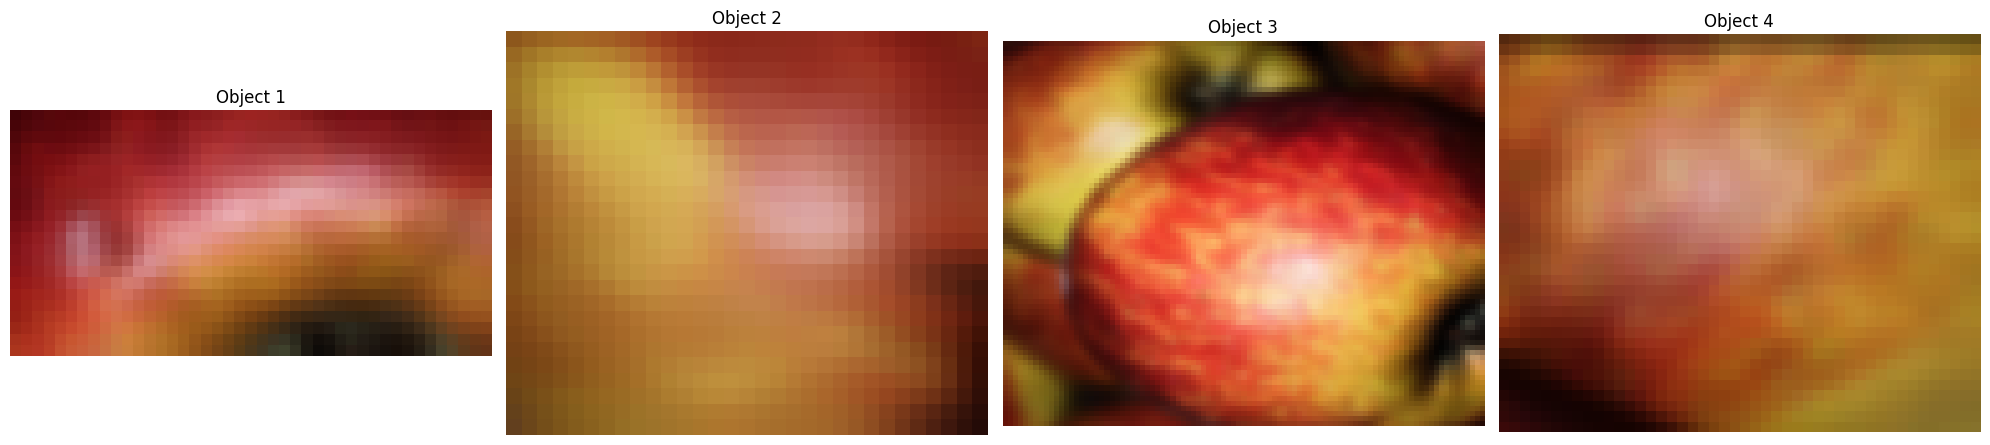

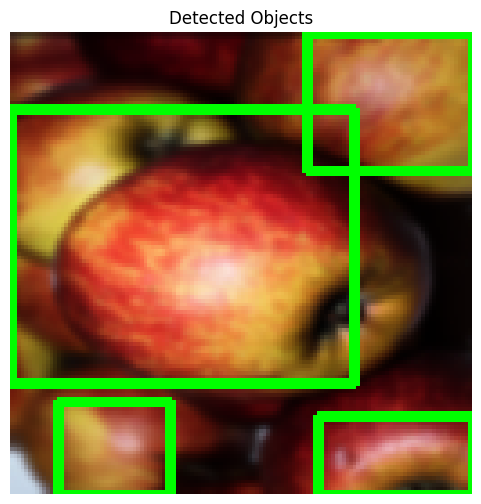

In [4]:
# ------------------- CONTOUR + Cropping -------------------

def apply_contour_and_crop(original_img, binary_mask):
    # Ensure binary mask is binary
    binary_mask = cv2.threshold(binary_mask, 0, 255, cv2.THRESH_BINARY)[1]

    # Find contours from the binary mask      #Only outer contours  #Compresses horizontal, vertical, and diagonal lines into their endpoints only  (low memory usage)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    object_images = []
    object_bboxes = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h < 500:  # filter small noise regions
            continue
        cropped = original_img[y:y+h, x:x+w]
        if cropped.size == 0:   # check to avoid adding empty images.
            continue
        object_images.append(cropped)
        object_bboxes.append((x, y, w, h))

    # Optional: Draw contours on a copy of the image
    img_with_boxes = original_img.copy()
    for (x, y, w, h) in object_bboxes:
        cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return img_with_boxes, object_images, object_bboxes


# ------------------- Full Pipeline Function -------------------

def process_and_segment_image(img_path):
    img = load_image(img_path)
    img = resize(img)
    img = augment_image(img)
    img = apply_histogram_equalization(img)
    img = apply_gaussian_blur(img)
    img = sharpen_unsharp_mask(img)

    hls_img = convert_to_hls(img)
    threshold_mask = apply_otsu_threshold(hls_img)
    morphed_mask = apply_morphology(threshold_mask)

    # Use contour-based object detection instead of watershed
    contour_result, object_images, object_bboxes = apply_contour_and_crop(img, morphed_mask)

    return {
        "original_img": img,
        "binary_mask": morphed_mask,
        "contour_overlay": contour_result,
        "object_images": object_images,
        "object_bboxes": object_bboxes,
        "normalized_img": normalize_for_cnn(img)
    }

# ------------------- Visualization Helper -------------------

def show_segmented_objects(object_images, title_prefix="Object"):
    num_objects = len(object_images)
    plt.figure(figsize=(5 * num_objects, 5))
    for i, obj in enumerate(object_images):
        plt.subplot(1, num_objects, i + 1)
        plt.imshow(cv2.cvtColor(obj, cv2.COLOR_BGR2RGB))
        plt.title(f"{title_prefix} {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def show_bounding_boxes(base_img, bboxes):
    boxed = base_img.copy()
    for (x, y, w, h) in bboxes:
        cv2.rectangle(boxed, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(boxed, cv2.COLOR_BGR2RGB))
    plt.title("Detected Objects")
    plt.axis('off')
    plt.show()

# Example usage on a single image
img_path = r"C:\Users\LENOVO\Desktop\subjects\computer vision\project\Fruit-Images-Dataset\Train\apple fruit\Image_26.jpg"
result = process_and_segment_image(img_path)

# Visualize cropped object images
show_segmented_objects(result["object_images"])

# Visualize bounding boxes on the original image
show_bounding_boxes(result["original_img"], result["object_bboxes"])



MODEL WITH LARGEST SEGMENTED REIGON ENTERD TO CLASSIFIER TO UP ACCOURACY

In [4]:
# import os
# import cv2
# import numpy as np
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.utils import to_categorical
# from sklearn.preprocessing import LabelEncoder

# IMG_SIZE = (128, 128)

# # Load MobileNetV2 as feature extractor
# mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='avg')

# # --- Normalize image for MobileNetV2 ---
# def normalize_for_cnn(img):
#     img = img.astype('float32') / 255.0
#     return img

# # --- Get largest segmented object ---
# def get_largest_segment(image, contours):
#     max_area = 0
#     best_crop = None
#     for cnt in contours:
#         x, y, w, h = cv2.boundingRect(cnt)
#         area = w * h
#         if area > max_area:
#             max_area = area
#             best_crop = image[y:y+h, x:x+w]
#     return best_crop

# # --- Your custom image preprocessing + segmentation logic ---
# def process_and_segment_image(image_path):
#     image = cv2.imread(image_path)
#     image = cv2.resize(image, IMG_SIZE)

#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#     kernel = np.ones((3, 3), np.uint8)
#     opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

#     contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     largest = get_largest_segment(image, contours)
    
#     return largest

# # --- Extract feature for a single image ---
# def extract_features_from_image(obj_image):
#     obj_resized = cv2.resize(obj_image, IMG_SIZE)
#     norm = normalize_for_cnn(obj_resized)
#     input_tensor = np.expand_dims(norm, axis=0)
#     feat = mobilenet.predict(input_tensor, verbose=0)
#     return feat.squeeze()

# # --- Load and process dataset ---
# def load_dataset_from_dir(base_dir):
#     X = []
#     y = []
#     class_names = os.listdir(base_dir)

#     for label in class_names:
#         class_path = os.path.join(base_dir, label)
#         if not os.path.isdir(class_path):
#             continue
#         for fname in os.listdir(class_path):
#             fpath = os.path.join(class_path, fname)
#             try:
#                 largest_object = process_and_segment_image(fpath)
#                 if largest_object is not None:
#                     feature = extract_features_from_image(largest_object)
#                     X.append(feature)
#                     y.append(label)
#             except Exception as e:
#                 print(f"Skipping {fpath}: {e}")
#     return np.array(X), np.array(y)

# # Paths
# train_dir = r"C:\Users\LENOVO\Desktop\subjects\computer vision\project\Fruit-Images-Dataset\Train"
# test_dir = r"C:\Users\LENOVO\Desktop\subjects\computer vision\project\Fruit-Images-Dataset\Test"

# # Load datasets
# print("Processing training data...")
# X_train, y_train = load_dataset_from_dir(train_dir)

# print("Processing test data...")
# X_test, y_test = load_dataset_from_dir(test_dir)

# # Encode labels
# encoder = LabelEncoder()
# y_train_enc = to_categorical(encoder.fit_transform(y_train))
# y_test_enc = to_categorical(encoder.transform(y_test))

# # Define classification model
# model = Sequential([
#     Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
#     Dropout(0.5),
#     Dense(128, activation='relu'),
#     Dropout(0.3),
#     Dense(y_train_enc.shape[1], activation='softmax')
# ])

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

# # Train model
# model.fit(X_train, y_train_enc, validation_data=(X_test, y_test_enc), epochs=15, batch_size=32)

# # === Save trained model ===
# model.save("fruit_classifier.h5")
# print("Model saved as 'fruit_classifier.h5'")

# # === Save label encoder ===
# import pickle
# with open("label_encoder.pkl", "wb") as f:
#     pickle.dump(encoder, f)
# print("Label encoder saved as 'label_encoder.pkl'")



Processing training data...
Error processing C:\Users\LENOVO\Desktop\subjects\computer vision\project\Fruit-Images-Dataset\Train\mango fruit\Image_13.gif: Image not loaded.
Loaded 4492 samples from C:\Users\LENOVO\Desktop\subjects\computer vision\project\Fruit-Images-Dataset\Train
Processing test data...
Loaded 1648 samples from C:\Users\LENOVO\Desktop\subjects\computer vision\project\Fruit-Images-Dataset\Test


c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,993 (1.38 MB)

 Trainable params: 361,993 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2558 - loss: 2.1768 - val_accuracy: 0.5346 - val_loss: 1.4248
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4570 - loss: 1.6287 - val_accuracy: 0.5868 - val_loss: 1.2431
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5314 - loss: 1.3973 - val_accuracy: 0.6590 - val_loss: 1.1195
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5597 - loss: 1.3081 - val_accuracy: 0.6650 - val_loss: 1.0329
Epoch 5/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5841 - loss: 1.2324 - val_accuracy: 0.6899 - val_loss: 0.9243
Epoch 6/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6112 - loss: 1.1452 - val_accuracy: 0.7142 - val_loss: 0.8972
Epoch 7/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6308 - loss: 1.1116 - val_accuracy: 0.7275 - val_loss: 0.8420
Epoch 8/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6397 - loss: 1.0540 - val_accuracy: 0.

Model saved as 'fruit_classifier.h5'
Label encoder saved as 'label_encoder.pkl'
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Test Accuracy: 0.8258

Classification Report:
                  precision    recall  f1-score   support

     apple fruit       0.82      0.73      0.78        83
    banana fruit       0.90      0.85      0.87       268
    cherry fruit       0.93      0.72      0.81       262
   chickoo fruit       0.91      0.80      0.85       131
    grapes fruit       0.67      0.93      0.78       383
      kiwi fruit       1.00      0.86      0.93        87
     mango fruit       0.81      0.69      0.75        81
    orange fruit       0.86      0.84      0.85        50
strawberry fruit       0.91      0.83      0.87       303

        accuracy                           0.83      1648
       macro avg       0.87      0.81      0.83      1648
    weighted avg       0.85      0.83      0.83      1648



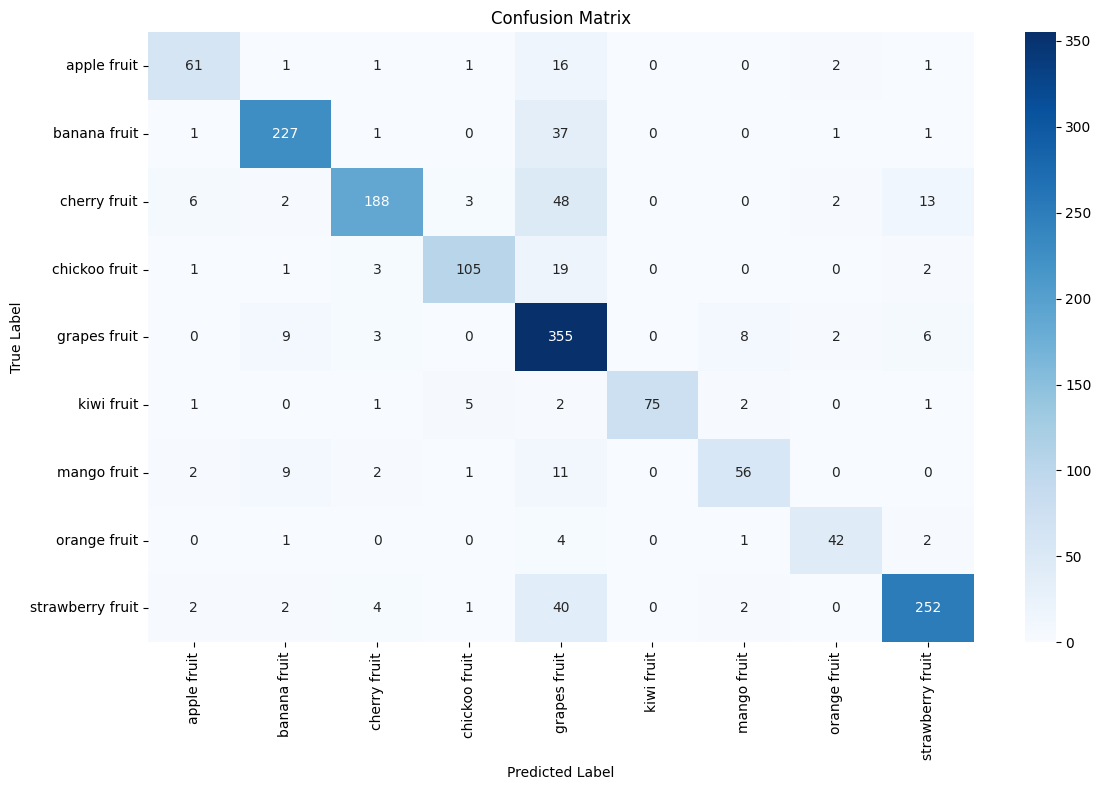

In [ ]:
import os
import cv2
import numpy as np
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import pickle

IMG_SIZE = (128, 128)

# Load MobileNetV2 as a feature extractor (no top layers)
                                           #pre-trained weights
mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='avg')

# --- Extract features from full image ---
def extract_features_from_segmented_objects(image_path):
    try:
        result = process_and_segment_image(image_path)
        object_images = result["object_images"]
        features = []

        for obj_img in object_images:
            obj_resized = cv2.resize(obj_img, IMG_SIZE)
            obj_norm = normalize_for_cnn(obj_resized)
            input_tensor = np.expand_dims(obj_norm, axis=0)
            feat = mobilenet.predict(input_tensor, verbose=0)
            features.append(feat.squeeze())

        return features  # List of features from cropped objects
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return []  # Return empty list on failure

# --- Load dataset from folder ---
def load_dataset_from_dir(base_dir):
    X = []
    y = []
    class_names = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    for label in class_names:
        class_path = os.path.join(base_dir, label)
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            try:
                feature_list = extract_features_from_segmented_objects(fpath)
                for feat in feature_list:
                    X.append(feat)
                    y.append(label)
            except Exception as e:
                print(f"Skipping {fpath}: {e}")
    print(f"Loaded {len(X)} samples from {base_dir}")
    return np.array(X), np.array(y)


# Paths to your dataset
train_dir = r"C:\Users\LENOVO\Desktop\subjects\computer vision\project\Fruit-Images-Dataset\Train"
test_dir = r"C:\Users\LENOVO\Desktop\subjects\computer vision\project\Fruit-Images-Dataset\Test"

# Load data
print("Processing training data...")
X_train, y_train = load_dataset_from_dir(train_dir)

print("Processing test data...")
X_test, y_test = load_dataset_from_dir(test_dir)

# Label encoding
encoder = LabelEncoder()
y_train_enc = to_categorical(encoder.fit_transform(y_train))
y_test_enc = to_categorical(encoder.transform(y_test))

# Define classifier model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_train_enc.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train model
model.fit(X_train, y_train_enc, validation_data=(X_test, y_test_enc), epochs=15, batch_size=32)

# Save trained model and label encoder
model.save("fruit_classifier.h5")
print("Model saved as 'fruit_classifier.h5'")

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)
print("Label encoder saved as 'label_encoder.pkl'")

# --- Evaluation ---
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_enc, axis=1)  # Fix: convert one-hot to labels

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


Segment all objects in the uploaded image.

Classify each segmented object.

For each class label (e.g., "apple", "banana"):

Find only the largest object (bounding box) for that class.

Display only one box and label per class (the largest one).

In [7]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import cv2
import numpy as np
import os
import shutil
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNetV2
import pickle

# === Load classifier and label encoder ===
model = load_model("fruit_classifier.h5")
with open("label_encoder.pkl", "rb") as f:
    encoder = pickle.load(f)

mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='avg')
IMG_SIZE = (128, 128)

# === Feature extraction ===
def extract_features(img):
    resized = cv2.resize(img, IMG_SIZE)
    norm = resized.astype('float32') / 255.0
    input_tensor = np.expand_dims(norm, axis=0)
    features = mobilenet.predict(input_tensor, verbose=0)
    return features.squeeze()

# === Segment using contours ===
def segment_with_contours(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Preprocess: blur + sharpen
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    sharpen_kernel = np.array([[-1, -1, -1],
                                [-1,  9, -1],
                                [-1, -1, -1]])
    sharpen = cv2.filter2D(blur, -1, sharpen_kernel)

    # Try Otsu threshold first
    _, thresh = cv2.threshold(sharpen, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Invert background if needed
    if np.mean(thresh) > 127:
        thresh = cv2.bitwise_not(thresh)

    # Morph close to fill gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bboxes = []
    crops = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 30:  # Reduce threshold to detect smaller objects
            crop = image[y:y+h, x:x+w]
            bboxes.append((x, y, w, h))
            crops.append(crop)
    return crops, bboxes


# === GUI Class ===
class FruitClassifierGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Fruit Classifier")
        self.canvas = tk.Canvas(root, width=600, height=600)
        self.canvas.pack()
        self.button = tk.Button(root, text="Select Image", command=self.select_image)
        self.button.pack()

    def select_image(self):
        path = filedialog.askopenfilename()
        if path:
            save_dir = "saved_uploads"
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, os.path.basename(path))
            shutil.copy(path, save_path)

            img = cv2.imread(save_path)
            crops, boxes = segment_with_contours(img)

            for crop, (x, y, w, h) in zip(crops, boxes):
                features = extract_features(crop)
                prediction = model.predict(np.expand_dims(features, axis=0), verbose=0)
                label = encoder.classes_[np.argmax(prediction)]

                # Draw box and label
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            self.display_image(img)

    def display_image(self, img_bgr):
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
        img_pil = img_pil.resize((600, 600))
        imgtk = ImageTk.PhotoImage(image=img_pil)
        self.canvas.create_image(0, 0, anchor="nw", image=imgtk)
        self.canvas.image = imgtk  # Prevent garbage collection

# === Run GUI ===
if __name__ == "__main__":
    root = tk.Tk()
    app = FruitClassifierGUI(root)
    root.mainloop()
